In [2]:
import torch
from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Initialize SuperPoint and LightGlue models
extractor = SuperPoint(max_num_keypoints=5000).eval().cuda()
matcher = LightGlue(features='superpoint').eval().cuda()

In [4]:
def extract_features(image_path, extractor):
    image = load_image(image_path).cuda()
    features = extractor.extract(image)
    return features

def find_top_matches(features1, features2, matcher):
    matches = matcher({'image0': features1, 'image1': features2})
    return matches['matches']

# Path to your dataset
dataset_path = 'images/'
image_features = {}

# Extract features for all images in the dataset
for img_name in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img_name)
    features = extract_features(img_path, extractor)
    image_features[img_name] = features

In [4]:
query_image_path = 'images/neuschwanstein_castle5.jfif'
query_features = extract_features(query_image_path, extractor)
print(query_features['keypoints'].shape)

torch.Size([1, 2035, 2])


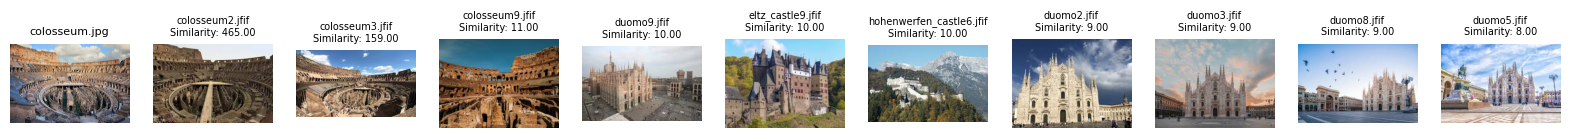

Correct matches for colosseum.jpg: 3/10


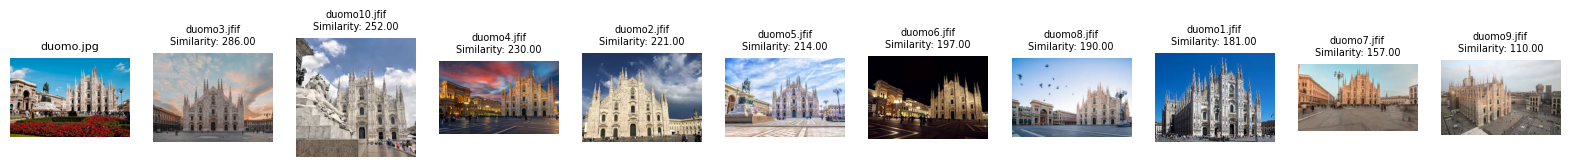

Correct matches for duomo.jpg: 10/10


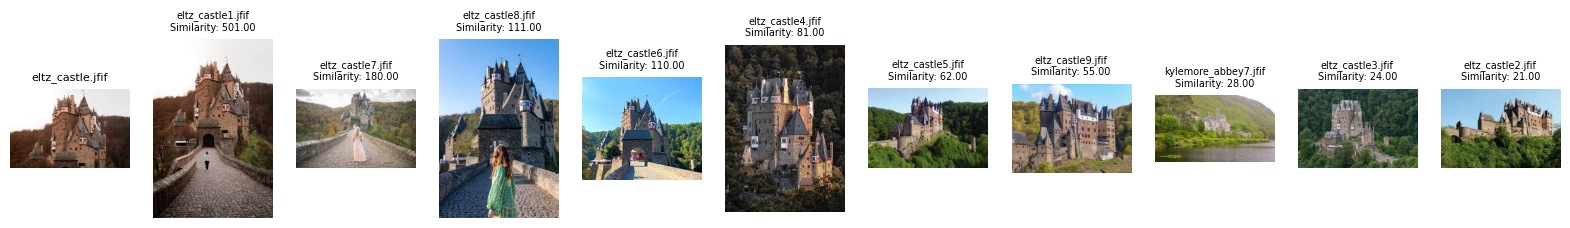

Correct matches for eltz_castle.jfif: 9/10


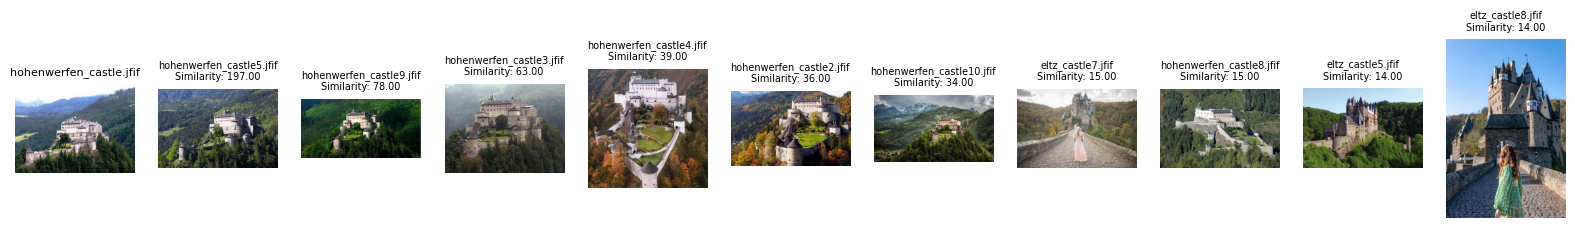

Correct matches for hohenwerfen_castle.jfif: 7/10


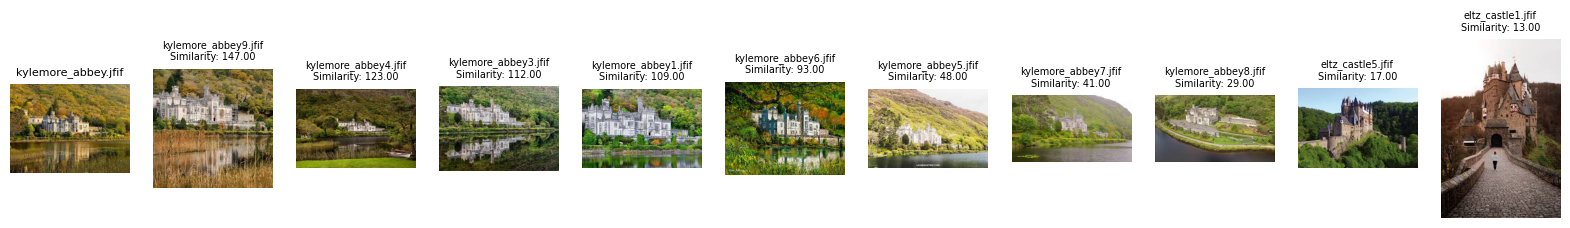

Correct matches for kylemore_abbey.jfif: 8/10


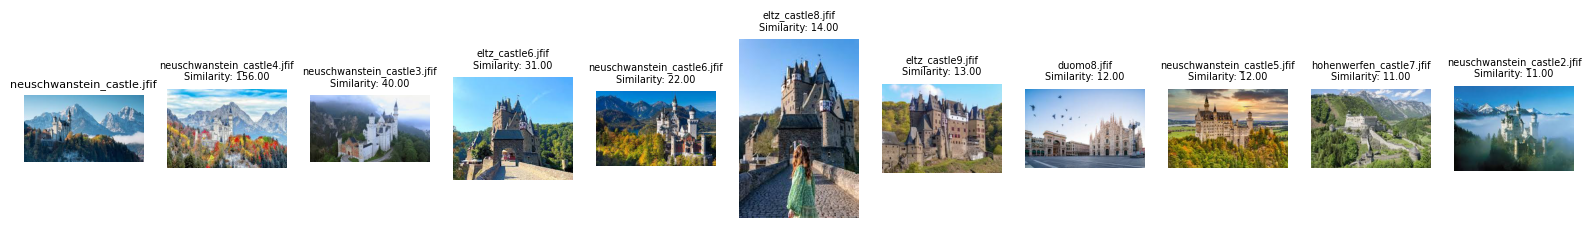

Correct matches for neuschwanstein_castle.jfif: 5/10
Total accuracy: 70.00%


In [7]:
import matplotlib.image as mpimg
import cv2 

def evaluate_and_plot(test_folder, image_features, extractor, matcher, top_n=5):
    total_correct = 0
    total_images = 0
    for test_img_name in os.listdir(test_folder):
        test_img_path = os.path.join(test_folder, test_img_name)
        
        query_features = extract_features(test_img_path, extractor)
        similarities = {}
        for img_name, features in image_features.items():
            matches = find_top_matches(query_features, features, matcher)
            #similarities[img_name] = len(matches[0])
            match_pairs = matches[0].cpu().numpy()
            kp1 = query_features['keypoints'][0][match_pairs[:, 0]]
            kp1 = kp1.cpu().numpy()
            kp2 = features['keypoints'][0][match_pairs[:, 1]]
            kp2 = kp2.cpu().numpy()
            if len(kp1) >= 4:  # RANSAC requires at least 4 points
                H, inliers = cv2.findHomography(kp1, kp2, cv2.RANSAC)
                inliers = inliers.ravel().astype(bool)
                inlier_matches = matches[0][inliers]
                similarities[img_name] = len(inlier_matches)
            else:
                similarities[img_name] = 0
            
        top_matches = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:top_n]

        correct_matches = 0
        query_prefix = test_img_name.split('.')[0]   
        fig, axes = plt.subplots(1, top_n + 1, figsize=(20, 10))

        query_img = mpimg.imread(test_img_path)
        #print(query_img.shape)
        axes[0].imshow(query_img)
        axes[0].set_title(test_img_name, fontsize=8)
        axes[0].axis('off')

        for i, (img_name, similarity) in enumerate(top_matches):
            match_prefix = ''.join([c for c in img_name if not c.isdigit()]).split('.')[0]
            if match_prefix == query_prefix:
                correct_matches += 1
            img_path = os.path.join(images_folder, img_name)
            matched_img = mpimg.imread(img_path)
            axes[i + 1].imshow(matched_img)
            axes[i + 1].set_title(f"{img_name}\nSimilarity: {similarity:.2f}", fontsize=7)
            axes[i + 1].axis('off')

        plt.show()
        print(f'Correct matches for {test_img_name}: {correct_matches}/{top_n}')
        
        total_correct += correct_matches
        total_images += 1

    accuracy = total_correct / (total_images * top_n)
    print(f'Total accuracy: {accuracy * 100:.2f}%')

# Paths
images_folder = 'images'
test_folder = 'test'

# Evaluate and plot results
evaluate_and_plot(test_folder, image_features, extractor, matcher, top_n=10)